In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import matplotlib.pyplot as plt
from scipy.stats import zscore

# COLLECTING AND PREPARING DATA

In [21]:
df = pd.read_csv("../coordinates.csv")

In [23]:
df.shape

(217, 133)

### Data Cleaning ( finding and removing outliers using ZScore and IQR method ) 

In [35]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
z_scores = zscore(df[numeric_columns])
abs_z_scores = abs(z_scores)
outliers_zscore = (abs_z_scores > 3).all(axis=1)

# Check for outliers using IQR method
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Combine both methods to identify potential outliers
potential_outliers = outliers_zscore | outliers_iqr

# Print the potential outliers
print("Potential Outliers:")
print(df[potential_outliers])

Potential Outliers:
             class        x1        y1        z1        v1        x2  \
0         HANDS UP  0.586977  0.330542 -0.285155  0.999943  0.604187   
37        HANDS UP  0.549471  0.345413 -0.304280  0.999967  0.564642   
38        HANDS UP  0.547908  0.345486 -0.256045  0.999969  0.562328   
39        HANDS UP  0.548428  0.345537 -0.236219  0.999970  0.562211   
40        HANDS UP  0.547834  0.346125 -0.279960  0.999972  0.560774   
..             ...       ...       ...       ...       ...       ...   
211  CROSSED HANDS  0.585083  0.350328 -0.193202  0.999617  0.599376   
213  CROSSED HANDS  0.586199  0.350545 -0.124090  0.999658  0.599826   
214  CROSSED HANDS  0.586188  0.350439 -0.078004  0.999688  0.599870   
215  CROSSED HANDS  0.587176  0.350621 -0.141771  0.999708  0.600415   
216  CROSSED HANDS  0.588236  0.351934 -0.187383  0.999729  0.601458   

           y2        z2        v2        x3  ...       z31       v31  \
0    0.297117 -0.248894  0.999592  0.614235

In [36]:
df_cleaned = df[~potential_outliers]

## VISUALIZING DATA

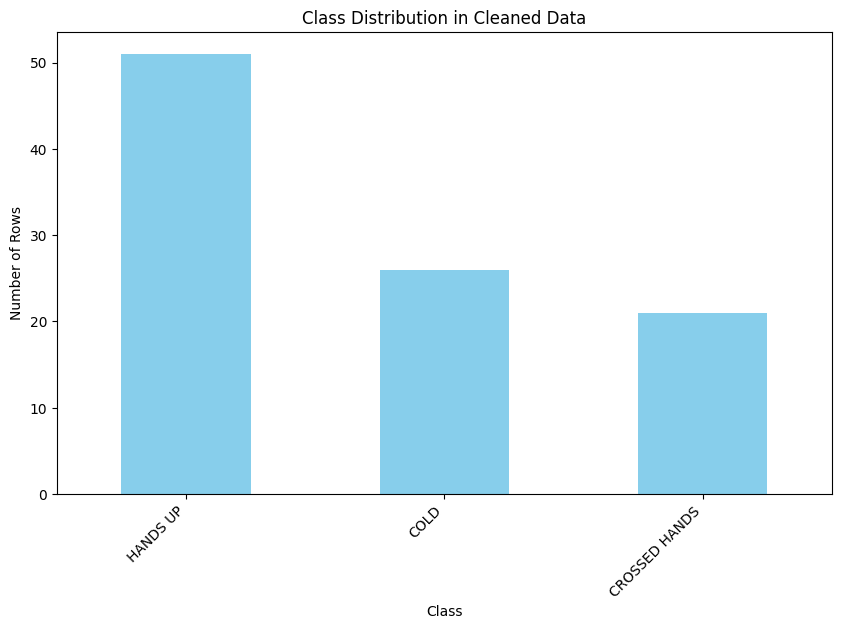

In [45]:
class_counts = df_cleaned['class'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Rows')
plt.title('Class Distribution in Cleaned Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [50]:
df_cleaned.shape     # earlier 217 rows , now 98 rows

(98, 133)

In [37]:
# Split the data into features (x) and target values (y)
x = df_cleaned.drop(['class'], axis=1)   # features
y = df_cleaned['class']   # target values

In [38]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

In [81]:
def train_and_evaluate_classifier(X_train, X_val, X_test, y_train, y_val, y_test, clf):
    model = make_pipeline(StandardScaler(), clf)
    model.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Evaluate on the test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Metrics for {clf.__class__.__name__}:")
    print(f"  Validation Accuracy: {val_accuracy}")
    print(f"  Test Accuracy: {test_accuracy}")

    return model, val_accuracy, test_accuracy, clf.__class__.__name__

In [53]:
def plot_validation_test_curves(classifiers, val_accuracies, test_accuracies):
    plt.figure(figsize=(10, 6))

    for clf_name, val_acc, test_acc in zip(classifiers, val_accuracies, test_accuracies):
        plt.plot(val_acc, label=f'{clf_name} - Validation', marker='o', linestyle='-', linewidth=2)
        plt.plot(test_acc, label=f'{clf_name} - Test', marker='o', linestyle='-', linewidth=2)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation and Test Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
def plot_confusion_matrix(model, X_test, y_test, class_labels, clf_name):
    y_pred = model.predict(X_test)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                                        display_labels=class_labels)
    cm_display.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
    plt.title(f'Confusion Matrix - {clf_name}')
    plt.show()

In [55]:
def save_model(model, filename):
    with open(filename, 'wb') as model_file:
        pickle.dump(model, model_file)
    print(f"The model has been saved as {filename}")

In [56]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

Metrics for LogisticRegression:
  Validation Accuracy: 1.0
  Test Accuracy: 1.0


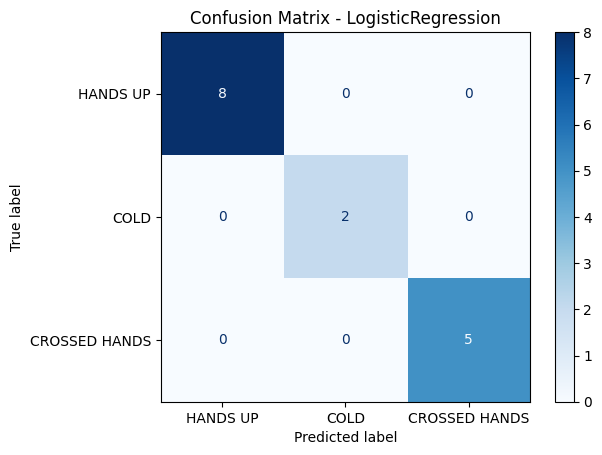

Metrics for RandomForestClassifier:
  Validation Accuracy: 1.0
  Test Accuracy: 1.0


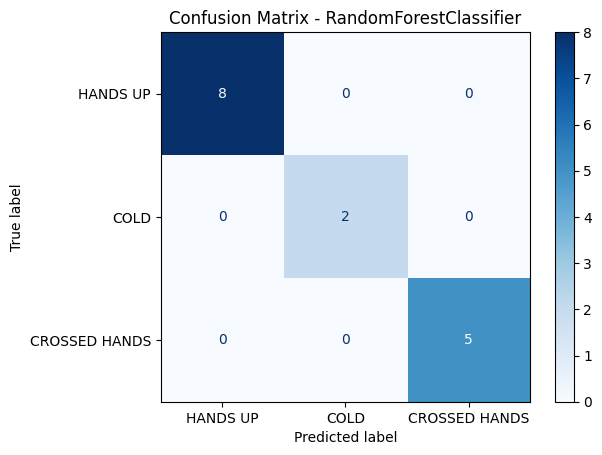

Metrics for GradientBoostingClassifier:
  Validation Accuracy: 1.0
  Test Accuracy: 1.0


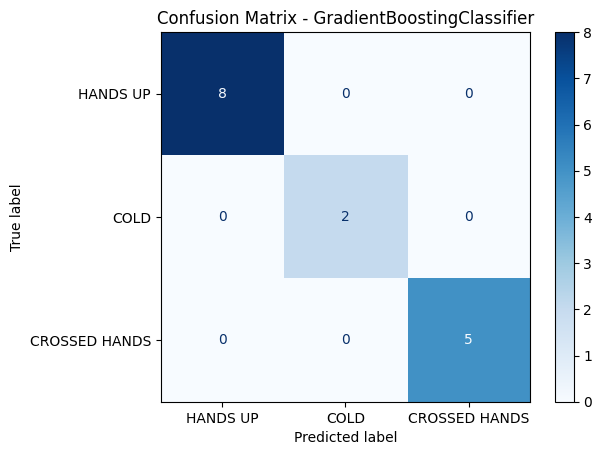


The best model (LogisticRegression) has been selected with validation accuracy 1.0
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])
The model has been saved as best_model.pkl


In [82]:
best_model = None
best_val_accuracy = 0.0
best_classifier_name = None
val_accuracies = []
test_accuracies = []

for clf_name, clf in classifiers.items():
    model, val_accuracy, test_accuracy, classifier_name = train_and_evaluate_classifier(X_train, X_val, X_test, y_train, y_val, y_test, clf)
    plot_confusion_matrix(model, X_test, y_test, class_labels=df['class'].unique(), clf_name=classifier_name)

    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_classifier_name = classifier_name

print(f"\nThe best model ({best_classifier_name}) has been selected with validation accuracy {best_val_accuracy}")
print(best_model)
save_model(best_model, 'best_model.pkl')

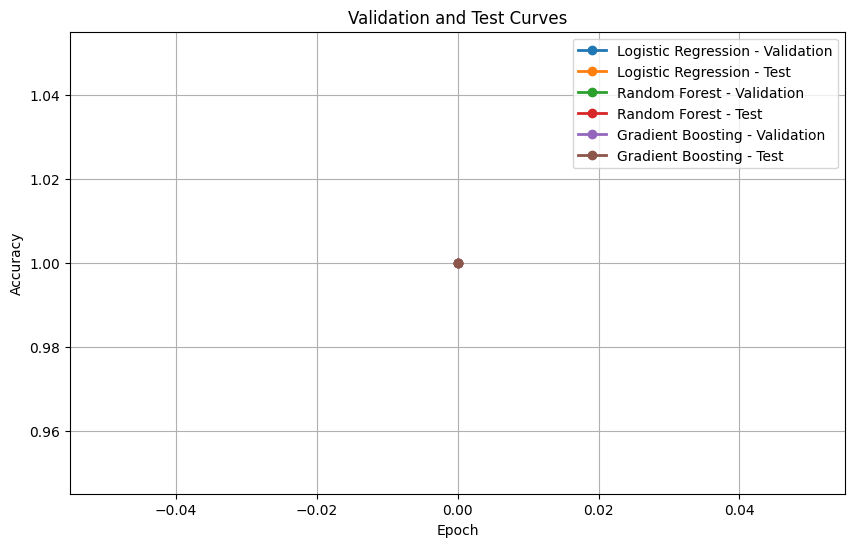

In [34]:
plot_validation_test_curves(classifiers.keys(), val_accuracies, test_accuracies)